# Akcja Segementacja
Autorka: Małgorzata Rucka

Celem wyzwania jest wykorzystanie uczenia nienadzorowanego do wykonania segmentacji klientów. 

## Pobieranie danych i importowanie bibliotek

In [1]:
import wget
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from zipfile import ZipFile


if not os.path.exists("Wyzwania Data Science_Machine Learning") :
    wget.download('https://files.assecobs.pl/s/tiMDR4gZYFiTYJ7/download')
    with ZipFile('Wyzwania%20Data%20Science_Machine%20Learning.zip', 'r') as zipObj:
        zipObj.extractall()
df = pd.read_csv("Wyzwania Data Science_Machine Learning/Customers.csv",index_col ='CustomerId' ,sep = ';', decimal = ',')
df.head()

,Profit,Recency,Frequency,Monetary,Variance
CustomerId,,,,,
1,187,63,1,2349.06,2
2,96,10,6,922.62,4
3,47,35,4,881.22,3
4,294,5,1,3815.16,2
5,732,4,31,41868.11,29


Opis kolumn:

-CustomerID - unikalny identyfikator klienta

-Profit - jak profit przynosi klient, wartość bez jednostki, im wyższa wartość tym lepiej

-Recency - ile dni temu było ostatnie zamówienie klienta, ilość w dniach, im niższa wartość tym lepiej

-Frequency - jak często klient zamawiał produkty, wartość bez jednostki, im wyższa wartość tym lepiej

-Monetary - całkowita wartość zamówionych produktów przez klienta, jednostka PLN, im wyższa wartość tym lepiej

-Variance - ilość różnorodnych produktów, które zostały zamówione przez klienta, wartość bez jednostki, im wyższa wartość tym lepiej

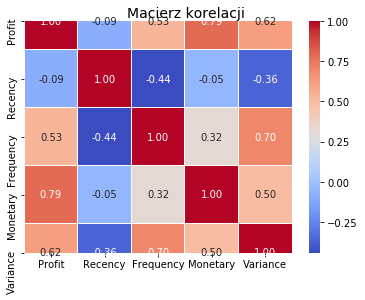

In [2]:
f, ax = plt.subplots()
corr = df.iloc[:,:5].corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)

t= f.suptitle('Macierz korelacji', fontsize=14)

Macierz korelacji potwierdza opisy danych. Dane, które chcemy, by były wyoskie są dodatnio ze sobą skorelowane, natomiast 'Recency', która im mniejsza, tym lepiej jest ujemnie skorelowana z resztą

## Badanie rozkładów danych.

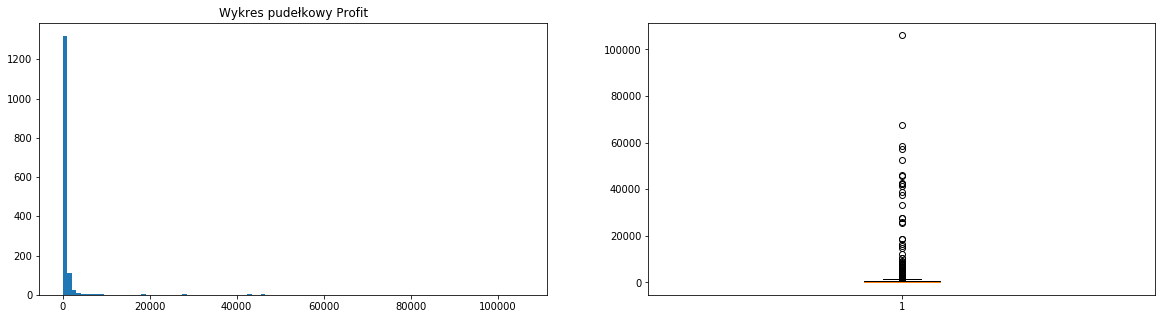

Różnica między średnią a medianą w kolumnie Profit : 878.39


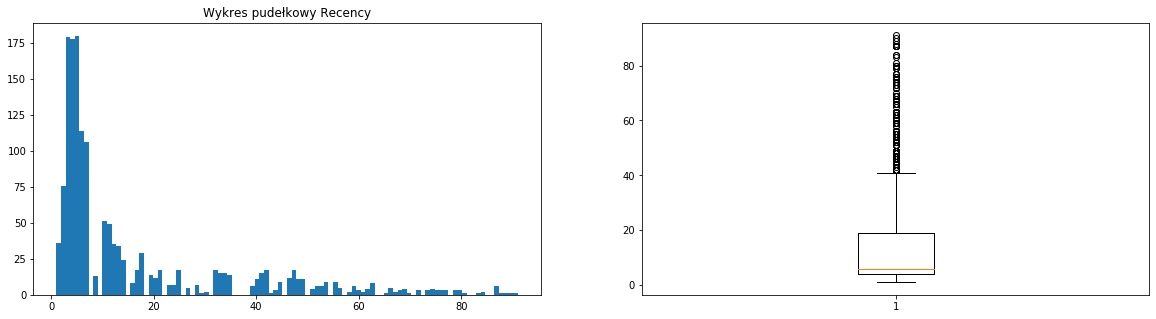

Różnica między średnią a medianą w kolumnie Recency : 9.85


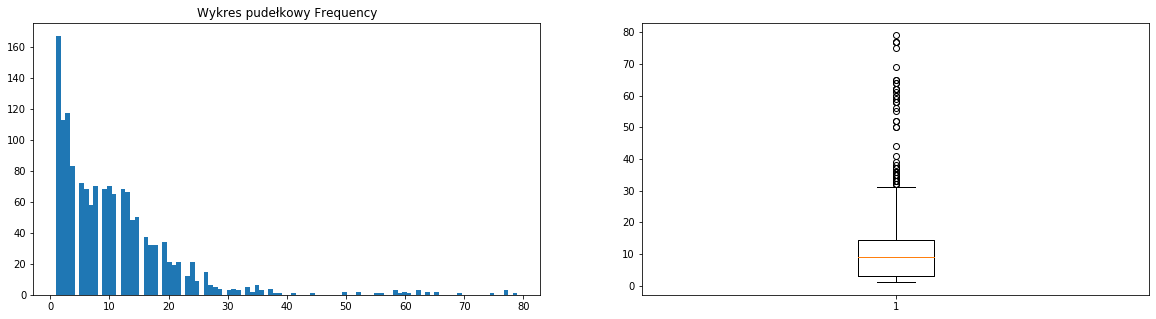

Różnica między średnią a medianą w kolumnie Frequency : 1.71


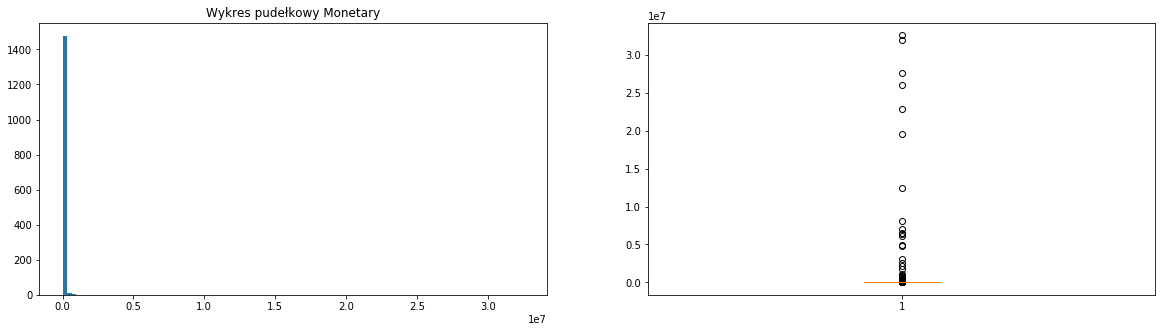

Różnica między średnią a medianą w kolumnie Monetary : 169580.57


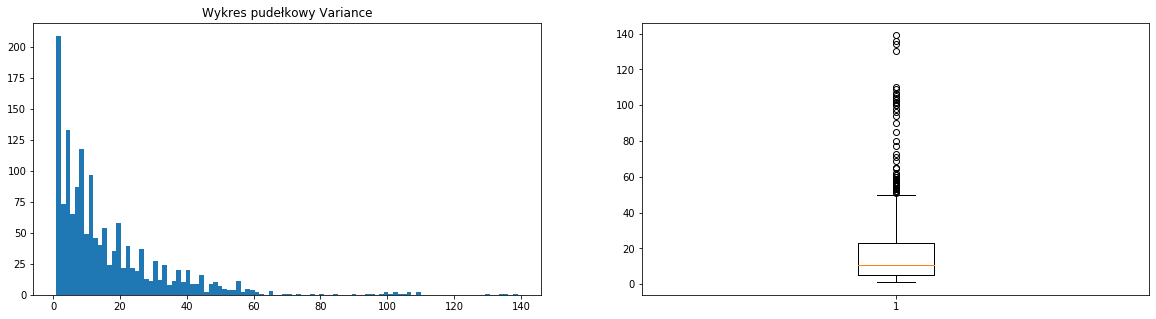

Różnica między średnią a medianą w kolumnie Variance : 5.67


In [3]:
for col in df.columns[:5]:
    if col != 'CustomerID':
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(20, 5)
        ax[0].hist(df[col],bins = 100)
        ax[0].set_title("Rozkład " + col)
        ax[1].boxplot(x=df[col])
        ax[0].set_title("Wykres pudełkowy " + col)
        plt.show()
        print('Różnica między średnią a medianą w kolumnie {} : {:.2f}'.format(col, df[col].mean()-df[col].median()))

## Skalowanie
Nasze dane mają bardzo różne zakresy, dlatego konieczne będzie skalowanie. Wszystkie kolumny danych mają prawostronnie skośne rozkłady, dlatego najlepiej użyć transformacji logarytmicznej, dzięki której odległość między punktami będzie zachowana.

In [4]:
for col in df.columns:
    df["log_" + col] = np.log1p(df[col])
df.head()

,Profit,Recency,Frequency,Monetary,Variance,log_Profit,log_Recency,log_Frequency,log_Monetary,log_Variance
CustomerId,,,,,,,,,,
1,187,63,1,2349.06,2,5.236442,4.158883,0.693147,7.762196,1.098612
2,96,10,6,922.62,4,4.574711,2.397895,1.945910,6.828301,1.609438
3,47,35,4,881.22,3,3.871201,3.583519,1.609438,6.782441,1.386294
4,294,5,1,3815.16,2,5.686975,1.791759,0.693147,8.247000,1.098612
5,732,4,31,41868.11,29,6.597146,1.609438,3.465736,10.642304,3.401197


## Usuwanie outlinerów

Korzystając z metody boxplotowej znaleziono i usunięto outlinery. Zostały zapisane w kolumnie 'outlier' jako True.

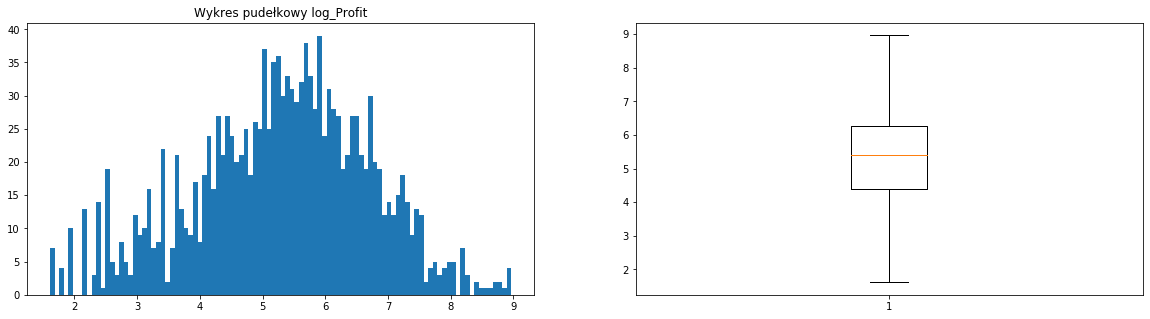

Różnica między średnią a medianą w kolumnie log_Profit : -0.10


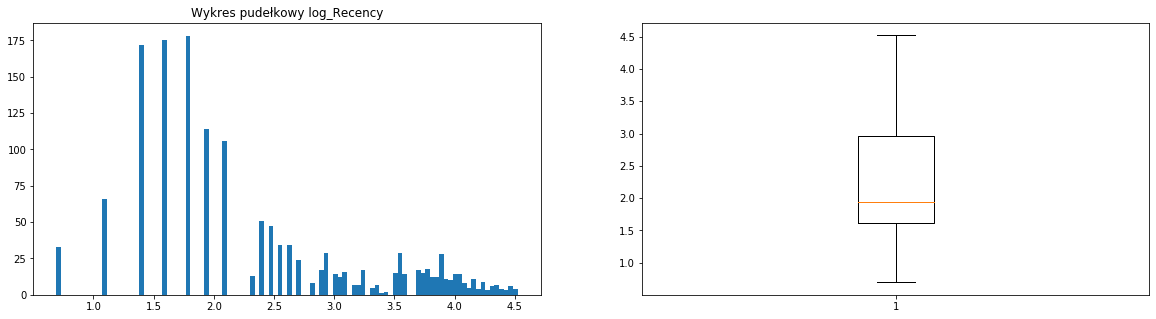

Różnica między średnią a medianą w kolumnie log_Recency : 0.39


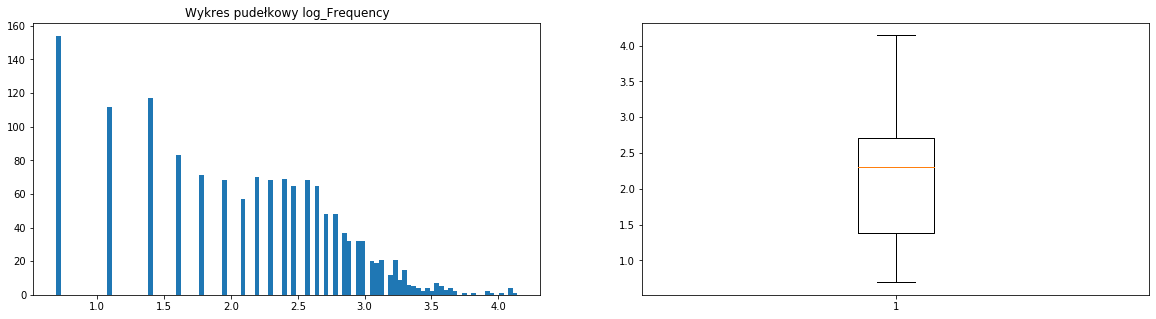

Różnica między średnią a medianą w kolumnie log_Frequency : -0.09


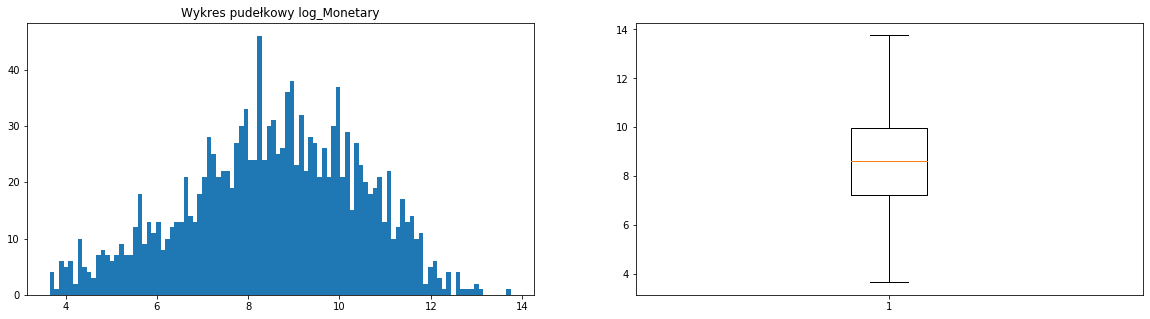

Różnica między średnią a medianą w kolumnie log_Monetary : -0.11


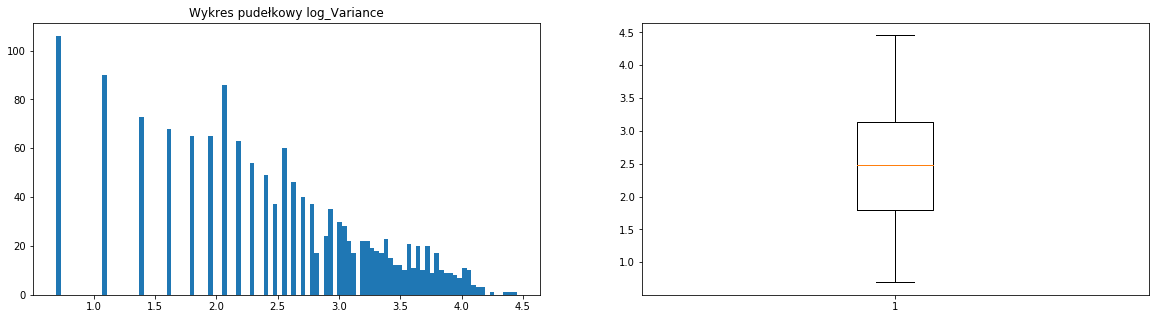

Różnica między średnią a medianą w kolumnie log_Variance : -0.07
Liczba znalezionych outlinerów:  43


In [5]:
for col in df.columns[5:10]:
    if col != 'CustomerID':
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(20, 5)
        ax[0].hist(df.loc[((df['log_Profit']>1.4) & (9>df['log_Profit'])) & ((df['log_Monetary']>3) & (df['log_Monetary']<14)), col],bins = 100)
        ax[0].set_title("Rozkład " + col)
        ax[1].boxplot(x=df.loc[((df['log_Profit']>1.4) & (9>df['log_Profit'])) & ((df['log_Monetary']>3) & (df['log_Monetary']<14)), col])
        ax[0].set_title("Wykres pudełkowy " + col)
        plt.show()
        print('Różnica między średnią a medianą w kolumnie {} : {:.2f}'.format(col, df.loc[(df['log_Profit']>1.2) & (9>df['log_Profit']), col].mean()-df.loc[(df['log_Profit']>1.2) & (9>df['log_Profit']), col].median()))

def oulier_check(row):
    if ((row['log_Profit']>1.4) & (row['log_Profit']<9)) and ((row['log_Monetary']>3) & (row['log_Monetary']<14)): 
        return False
    else:
        return True
df['outlier'] = df.apply(oulier_check, axis = 1)
print('Liczba znalezionych outlinerów: ', list(df['outlier']).count(True))

## K-means

Odnaleziono optymalne k dla algorytmu k-means o wartości 4. Następnie dokonano segmentacji danych.

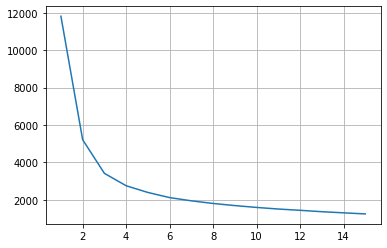

In [6]:
from sklearn.cluster import KMeans
def make_list_of_K(K, dataframe):
    cluster_values = list(range(1, K+1))
    inertia_values=[]
    
    for c in cluster_values:
        model = KMeans(
            n_clusters = c, 
            init='k-means++', 
            max_iter=500, 
            random_state=42)
        model.fit(dataframe)
        inertia_values.append(model.inertia_)
    
    return inertia_values

results = make_list_of_K(15, df.iloc[:,5:10].loc[df['outlier']!=True])
k_values_distances = pd.DataFrame({"clusters": list(range(1, 15+1)),
                                   "within cluster sum of squared distances": results})
plt.plot(k_values_distances['clusters'],k_values_distances['within cluster sum of squared distances'])
plt.grid()
plt.show()

In [7]:
updated_kmeans_model = KMeans(n_clusters = 4, 
                              init='k-means++', 
                              max_iter=500, 
                              random_state=42)
df.loc[df['outlier']!=True, 'SegmentID'] = updated_kmeans_model.fit_predict(df.iloc[:,5:10].loc[df['outlier']!=True])
df.loc[df['outlier']==True, 'SegmentID'] = -1

## Analiza otrzymanych segmentów

Przeprowadzając analizę RMF wywnioskowano następujące opisy klientów:

0 - lojalni klienci -'loyal'

1 - klienci którzy zakupili coś kilka razy, ale dawno nic nie zakupili, utraceni klienci - 'lost'

2 - najlepsi i najbardziej dochodowi klienci -'champions'

3 - klienci którzy potrzebują uwagi - zagrożenie utratą klienta -'need attention'

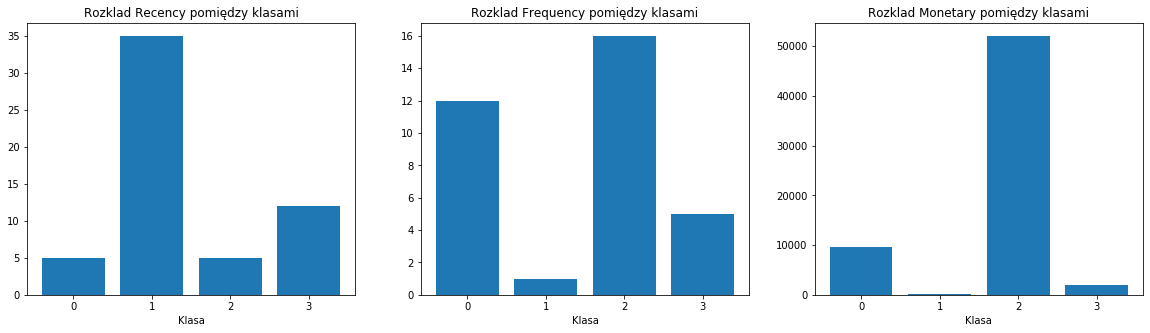

In [8]:
cols = ['Recency', 'Frequency', 'Monetary']
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20, 5)
for idx, col in enumerate(cols):
    median = []
    for i in range(4):
        median.append(df.loc[df['SegmentID']==i, col].median())
    ax[idx].bar(np.unique(updated_kmeans_model.labels_),median)
    ax[idx].set_title('Rozklad '+col+' pomiędzy klasami')
    ax[idx].set_xlabel('Klasa')
    ax[idx].set_xticks([0, 1, 2, 3])
    

In [9]:
df.loc[df['SegmentID'] == -1, 'SegmentName'] = 'outlier'
df.loc[df['SegmentID'] == 0, 'SegmentName'] = 'loyal'
df.loc[df['SegmentID'] == 1, 'SegmentName'] = 'lost'
df.loc[df['SegmentID'] == 2, 'SegmentName'] = 'champion'
df.loc[df['SegmentID'] == 3, 'SegmentName'] = 'need attention'
df.to_csv(r'customers.csv')